In [46]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Tuple
from scipy.ndimage import gaussian_filter

In [47]:

def read_mat_file(file_path):
    data = scipy.io.loadmat(file_path)
    return data

def split_3d_array(array_3d):
    # Ensure the array has the expected shape
    if array_3d.shape[2] != 5:
        raise ValueError("The loaded array does not have the expected third dimension size of 5.")
    
    # Extract the 2D arrays
    arrays = [array_3d[:, :, i] for i in range(5)]
    return arrays

In [48]:
data = read_mat_file("C:/Users/LEnsE/Documents/GitHub/camera-gui/applis/Zygo-labwork/_data/imgs2.mat")
images = data['Imgs']

In [49]:
images = split_3d_array(images)
images_filitrees = list(map(lambda x:gaussian_filter(x, 3), images))

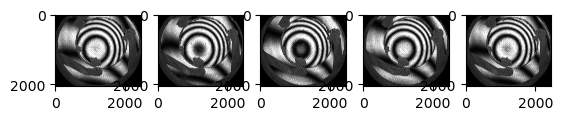

In [50]:
for i, img in enumerate(images_filitrees):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')

In [51]:
def hariharan_algorithm(intensity_1: np.ndarray, intensity_2: np.ndarray, intensity_3: np.ndarray, intensity_4: np.ndarray, intensity_5: np.ndarray) -> np.ndarray:
    num = 2 * (intensity_4 - intensity_2)
    denum = 2 * intensity_3 - intensity_5 - intensity_1
    return np.arctan2(num, denum)

In [52]:
phase = hariharan_algorithm(*images_filitrees)

`images` est une liste contenant les 5 interferogrammes obtenus

***

In [53]:
import numpy as np

def unwrap1(xe, sautLimite=np.pi, dim=None):
    """
    Déroule un vecteur de phase (Les NaNs sont correctement ignorés)
    
    Args:
        xe (numpy.ndarray): Tableau numérique dont on veut dérouler les vecteurs colonnes ou de la dimension dim.
        sautLimite (float, optional): Valeur du saut maximal toléré. Par défaut, sautLimite vaut pi.
        dim (int, optional): Scalaire entier strictement positif indiquant la dimension suivant laquelle
            le déroulement doit être effectué. Par défaut, le traitement est fait suivant la première dimension
            non réduite à 1.
    
    Returns:
        numpy.ndarray: Tableau de même dimension que xe contenant le résultat.
    """
    P = 2 * sautLimite
    
    sxe = np.shape(xe)
    if dim is None:
        dim = 0
        xe = np.squeeze(xe)
    else:
        dim -= 1
        xe = np.moveaxis(xe, dim, 0)
    
    yd = xe.copy()
    
    for j in range(sxe[dim]):
        y = yd[j]
        k = ~np.isnan(y)
        ysn = y[k]
        
        dysn = np.diff(ysn, prepend=0)
        saut = -np.round(dysn / P) * P
        
        yd[j, k] = ysn + np.cumsum(saut)
    
    if dim != 0:
        yd = np.moveaxis(yd, 0, dim)
    
    return yd


def unwrap2D(Ph):
    """
    Déroulement 2D de la phase
    
    Args:
        Ph (numpy.ndarray): Matrice réelle contenant les phases enroulées en détermination principale.
    
    Returns:
        numpy.ndarray: Matrice réelle de même taille que Ph contenant les phases déroulées.
    """
    PhDc = unwrap1(Ph)
    PhDl = unwrap1(Ph.T).T
    
    both = (~np.isnan(PhDc)) & (~np.isnan(PhDl))
    offsetBrut = np.mean(PhDc[both] - PhDl[both])
    offset = 2 * np.pi * round(offsetBrut / (2 * np.pi))
    ecarto = np.abs(offset - offsetBrut)
    
    pb = np.abs(PhDc - PhDl - offset) > np.pi / 10000
    
    Voffset = PhDc[both & (~pb)] - PhDl[both & (~pb)]
    offsetBrut = np.mean(Voffset)
    offset = 2 * np.pi * round(offsetBrut / (2 * np.pi))
    ecarttype = np.std(Voffset)
    
    NbPPb = np.sum(pb)
    NbBoth = np.sum(both)
    rapp = NbPPb / NbBoth
    
    info = [ecarttype, ecarto, rapp]
    
    tauxMaxPtsDiff = 0.05
    
    if rapp > tauxMaxPtsDiff or ecarttype > np.pi / 10000:
        Pb = True
        PhD = PhDc.copy()
        PhD[~both] = np.nan
        PhD[pb] = np.nan
    else:
        Pb = False
        PhD = PhDc.copy()
        PhD[~both] = PhDl[~both] + offset
        
        k, m = np.where(pb)
        for i, j in zip(k, m):
            if i in [0, PhD.shape[0]-1] or j in [0, PhD.shape[1]-1]:
                PhD[i, j] = np.nan
            else:
                errc = np.diff(PhDc[i, j-1:j+2])
                errl = np.diff(PhDl[i-1:i+2, j])
                Pbc = np.any(np.abs(errc) > np.pi)
                Pbl = np.any(np.abs(errl) > np.pi)
                
                if Pbc and Pbl:
                    PhD[i, j] = np.nan
                elif Pbc:
                    PhD[i, j] = PhDl[i, j] + offset
                elif Pbl:
                    pass
    
    return PhD


In [55]:
def selection_surface_utile(mask):
    a, b = mask.shape

    xmin = 0
    while xmin < a and np.sum(mask[xmin, :]) == 0:
        xmin += 1

    xmax = a - 1
    while xmax > 0 and np.sum(mask[xmax, :]) == 0:
        xmax -= 1

    ymin = 0
    while ymin < b and np.sum(mask[:, ymin]) == 0:
        ymin += 1

    ymax = b - 1
    while ymax > 0 and np.sum(mask[:, ymax]) == 0:
        ymax -= 1

    mask_select = mask[xmin:xmax+1, ymin:ymax+1]

    return mask_select, xmin, xmax, ymin, ymax


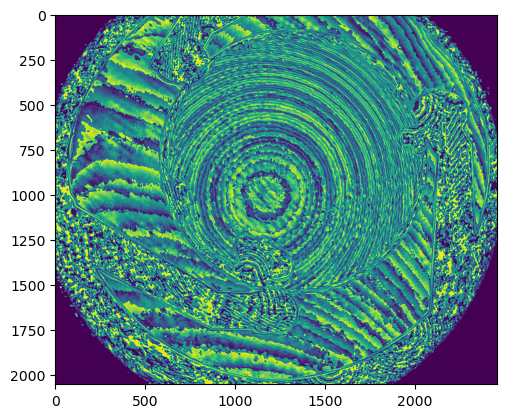

In [54]:
plt.imshow(unwrap2D(phase))